In [48]:
import time
import pandas as pd
import numpy as np
import math
import optuna
import joblib
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

## Load datasets

In [49]:
# Load datasets
# Train Data
temp_df = pd.read_csv("../data/cleaned/train.csv", nrows=0)  # Read only the header
total_columns = len(temp_df.columns)
columns_to_use = temp_df.columns[1:total_columns]
train_data = pd.read_csv("../data/cleaned/train.csv", usecols=columns_to_use)

# Test Data
test_data = pd.read_csv("../data/cleaned/test.csv", usecols=columns_to_use)

## Process datasets

In [50]:
# *** Do not drop 'date' column yet ***
train_data = train_data.drop(columns=['building_name', 'site_name', 'sqft'])
test_data = test_data.drop(columns=['building_name', 'site_name', 'sqft'])

# Convert 'date' column to datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])


# Building index on building_id for further assessment
train_data.set_index('building_id', inplace=True)
test_data.set_index('building_id', inplace=True)

# Define features and types based on dataset
numerical_features = ['sqm', 'airTemperature']
categorical_features = ['meter', 'primaryspaceusage', 'site_id', 'weekday', 'month']

results = []

### Drop the columns that we may not use during training

In [51]:
train_data.drop(columns=['sub_primaryspaceusage', 'timezone', 'season'], inplace=True)
test_data.drop(columns=['sub_primaryspaceusage', 'timezone', 'season'], inplace=True)

In [77]:
train_data.head()

,meter,date,meter_reading,primaryspaceusage,sqm,airTemperature,month,weekday,site_id
building_id,,,,,,,,,
1,electricity,2016-01-01,2.9050,Education,609.8,5.246861,1,4,1
1,electricity,2016-01-02,2.7700,Education,609.8,5.993973,1,5,1
1,electricity,2016-01-03,2.6725,Education,609.8,5.660314,1,6,1
1,electricity,2016-01-04,4.5650,Education,609.8,5.048507,1,0,1
1,electricity,2016-01-05,4.7825,Education,609.8,4.745567,1,1,1


In [78]:
cols = ['site_id', 'meter', 'date', 'primaryspaceusage', 'sqm', 'airTemperature']
train_data[cols].head()

,site_id,meter,date,primaryspaceusage,sqm,airTemperature
building_id,,,,,,
1,1,electricity,2016-01-01,Education,609.8,5.246861
1,1,electricity,2016-01-02,Education,609.8,5.993973
1,1,electricity,2016-01-03,Education,609.8,5.660314
1,1,electricity,2016-01-04,Education,609.8,5.048507
1,1,electricity,2016-01-05,Education,609.8,4.745567


In [80]:
train_data['primaryspaceusage'].unique()

array(['Education', 'Office'], dtype=object)

In [53]:
test_data.head()

,meter,date,meter_reading,primaryspaceusage,sqm,airTemperature,month,weekday,site_id
building_id,,,,,,,,,
1,electricity,2017-01-01,2.1775,Education,609.8,6.313140,1,6,1
1,electricity,2017-01-02,2.7925,Education,609.8,5.297363,1,0,1
1,electricity,2017-01-03,7.1100,Education,609.8,5.970330,1,1,1
1,electricity,2017-01-04,6.8450,Education,609.8,5.959649,1,2,1
1,electricity,2017-01-05,3.9500,Education,609.8,1.717660,1,3,1


In [54]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 672708 entries, 1 to 924
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   meter              672708 non-null  object        
 1   date               672708 non-null  datetime64[ns]
 2   meter_reading      672708 non-null  float64       
 3   primaryspaceusage  672708 non-null  object        
 4   sqm                672708 non-null  float64       
 5   airTemperature     672708 non-null  float64       
 6   month              672708 non-null  int64         
 7   weekday            672708 non-null  int64         
 8   site_id            672708 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 51.3+ MB


In [55]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 670290 entries, 1 to 924
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   meter              670290 non-null  object        
 1   date               670290 non-null  datetime64[ns]
 2   meter_reading      670290 non-null  float64       
 3   primaryspaceusage  670290 non-null  object        
 4   sqm                670290 non-null  float64       
 5   airTemperature     670290 non-null  float64       
 6   month              670290 non-null  int64         
 7   weekday            670290 non-null  int64         
 8   site_id            670290 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 51.1+ MB


In [84]:
test_data.sample(5)

,meter,date,meter_reading,primaryspaceusage,sqm,airTemperature,month,weekday,site_id
building_id,,,,,,,,,
491,electricity,2017-06-20,10899.0000,Office,18033.5,24.238393,6,1,9
377,chilledwater,2017-12-05,2737.4607,Office,2766.5,9.660965,12,1,7
697,steam,2017-03-25,23016.0060,Education,5416.9,11.240570,3,5,13
625,water,2017-08-18,1400.6017,Education,2200.4,21.950439,8,4,12
472,electricity,2017-01-31,2196.7530,Office,5332.1,4.523516,1,1,9


In [56]:
unique_meters = train_data['meter'].unique()
unique_meters

array(['electricity', 'chilledwater', 'gas', 'hotwater', 'solar', 'water',
       'steam', 'irrigation'], dtype=object)

## Define Evaluation metrics

In [57]:
# Define custom evaluation metrics
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return math.sqrt(mse)

def coefficient_of_variation_root_mean_squared_error(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    return rmse / np.mean(y_true) * 100

def mean_bias_error(y_true, y_pred):
    dif = y_true - y_pred
    return np.mean(dif)

def normalized_mean_bias_error(y_true, y_pred):
    dif = y_true - y_pred
    return (np.sum(dif) / (len(y_true) * np.mean(y_true))) * 100

def r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

## Data Preprocessing Functions for Model Training


In [58]:
# Function to preprocess data
def preprocess_data(X, y=None, fit_scaler=False, scaler=None, y_scaler=None):
    # Convert categorical features to 'category' type
    for cat_col in categorical_features:
        X[cat_col] = X[cat_col].astype('category')

    # Log-transform 'sqm' if it's a highly skewed feature
    if 'sqm' in X.columns:
        X['sqm'] = np.log1p(X['sqm'])

    # Scale numerical features
    if fit_scaler:
        scaler = StandardScaler()
        X[numerical_features] = scaler.fit_transform(X[numerical_features])
        
        if y is not None:
            
            # Cap y at the 99th percentile to handle outliers
            cap_value = np.percentile(y, 99)
            y = np.clip(y, None, cap_value)  # Cap extreme values
            
            # Log-transform and scale the target
            y_log = np.log1p(y)
            y_scaler = StandardScaler()
            y_scaled = y_scaler.fit_transform(y_log.values.reshape(-1, 1)).flatten()
            return X, y_scaled, scaler, y_scaler
        else:
            return X, scaler
    else:
        X[numerical_features] = scaler.transform(X[numerical_features])
        
        if y is not None:
            # Log-transform and scale the target using the provided scaler
            y_log = np.log1p(y)
            y_scaled = y_scaler.transform(y_log.values.reshape(-1, 1)).flatten()
            return X, y_scaled
        else:
            return X

## Model Optimization: Hyper-parameter Tuning Using Optuna

In [ ]:
# Optuna objective function for hyperparameter tuning
def objective(trial, X_train, y_train, X_valid, y_valid):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        "random_state": 42,
        'boosting_type': 'gbdt',
        'device': 'cpu',
        'verbosity': -1,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2000, 3000),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'learning_rate': 0.01,
        'max_depth': trial.suggest_int('max_depth', 100, 500),
        'max_bin': trial.suggest_int('max_bin', 500, 1000)
    }

    lgb_train = lgb.Dataset(X_train,
                            label=y_train,
                            categorical_feature=categorical_features)
    lgb_valid = lgb.Dataset(X_valid,
                            label=y_valid,
                            categorical_feature=categorical_features,
                            reference=lgb_train)

    model = lgb.train(
        param,
        lgb_train,
        valid_sets=[lgb_valid],
        num_boost_round=1000,
        callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(10)
        ]
    )

    preds = model.predict(X_valid, num_iteration=model.best_iteration)
    rmse = mean_squared_error(y_valid, preds, squared=False)
    return rmse


n_trials = 50
def progress_callback(study, trial):
    # Calculate the progress percentage
    progress = (len(study.trials) / n_trials) * 100
    print(f"Progress: {progress:.2f}% - Trial {len(study.trials)} of {n_trials}")


#### Process data for model optimization

In [ ]:
print(f"==============  Processing meter value: {meter_value} =====================")
# Filter data and preprocess
meter_filter = train_data['meter'] == meter_value
X_meter = train_data.loc[meter_filter].drop(columns=['meter_reading', 'meter', 'date'])
y_meter = train_data.loc[meter_filter, 'meter_reading']


# Split Train set (2016) to train and validation set
split_index = int(len(X_meter) * 0.8)
X_train_meter = X_meter.iloc[:split_index]
X_valid_meter = X_meter.iloc[split_index:]
y_train_meter = y_meter.iloc[:split_index]
y_valid_meter = y_meter.iloc[split_index:]

X_train_processed, y_train_scaled, scaler, y_scaler = preprocess_data(
     X_train_meter.copy(), y_train_meter, fit_scaler=True
)
X_valid_processed, y_valid_scaled = preprocess_data(
     X_valid_meter.copy(), y_valid_meter, fit_scaler=False, scaler=scaler, y_scaler=y_scaler
)

In [ ]:
print("================= Tunning hyperparameters with Optuna...=====================")
# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train_processed, y_train_scaled, X_valid_processed, y_valid_scaled),
                n_trials=n_trials,
                callbacks=[progress_callback])
best_params = study.best_params

print(f"================= Best parameters found by Optuna:{best_params} ============")

## Training Models

### Process training data (2016)

In [59]:
# Filter data and preprocess
X_meter = train_data.drop(columns=['meter_reading', 'date'])
y_meter = train_data['meter_reading']

X_train_full_processed, y_train_full_scaled, scaler, y_scaler = preprocess_data(
    X_meter.copy(), y_meter, fit_scaler=True
)

for col in categorical_features:
    X_train_full_processed[col] = X_train_full_processed[col].astype('category')

In [60]:
X_train_full_processed.head()

,meter,primaryspaceusage,sqm,airTemperature,month,weekday,site_id
building_id,,,,,,,
1,electricity,Education,-2.269816,-1.315060,1,4,1
1,electricity,Education,-2.269816,-1.205252,1,5,1
1,electricity,Education,-2.269816,-1.254292,1,6,1
1,electricity,Education,-2.269816,-1.344214,1,0,1
1,electricity,Education,-2.269816,-1.388739,1,1,1


In [61]:
X_train_full_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 672708 entries, 1 to 924
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   meter              672708 non-null  category
 1   primaryspaceusage  672708 non-null  category
 2   sqm                672708 non-null  float64 
 3   airTemperature     672708 non-null  float64 
 4   month              672708 non-null  category
 5   weekday            672708 non-null  category
 6   site_id            672708 non-null  category
dtypes: category(5), float64(2)
memory usage: 18.6 MB


### Process test data (2017)

In [62]:
X_test = test_data.drop(columns=['meter_reading', 'date'])
y_test = test_data['meter_reading']

X_test_processed, y_test_scaled = preprocess_data(
    X_test.copy(), y_test, fit_scaler=False, scaler=scaler, y_scaler=y_scaler  
)  # Must use the same scaler as the training set to prevent data leakage

# Ensure that categorical columns in X_test_processed have the same levels as in X_train_processed
for col in categorical_features:
    X_test_processed[col] = X_test_processed[col].astype('category')

In [63]:
X_test_processed.head()

,meter,primaryspaceusage,sqm,airTemperature,month,weekday,site_id
building_id,,,,,,,
1,electricity,Education,-2.269816,-1.158341,1,6,1
1,electricity,Education,-2.269816,-1.307638,1,0,1
1,electricity,Education,-2.269816,-1.208727,1,1,1
1,electricity,Education,-2.269816,-1.210297,1,2,1
1,electricity,Education,-2.269816,-1.833772,1,3,1


In [64]:
X_test_processed.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 670290 entries, 1 to 924
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   meter              670290 non-null  category
 1   primaryspaceusage  670290 non-null  category
 2   sqm                670290 non-null  float64 
 3   airTemperature     670290 non-null  float64 
 4   month              670290 non-null  category
 5   weekday            670290 non-null  category
 6   site_id            670290 non-null  category
dtypes: category(5), float64(2)
memory usage: 18.5 MB


### Define Parameters

* Ideally, we would use the parameters obtained from the model optimization process described above.
* However, to save time, we’ve opted to skip the hyperparameter tuning step and instead directly define a set of parameters.

In [65]:
best_params = {
    'num_leaves': 1000,                # Reduce to limit complexity
    'learning_rate': 0.01,           # Lower learning rate
    'max_bin': 512,                   # Reduce max_bin
    'lambda_l1': 0.01,                 # Add L1 regularization
    'lambda_l2': 0.01,                 # Add L2 regularization
    'min_child_samples': 20,          # Increase min_child_samples
    'max_depth': 15,                  # Limit max_depth
}

### Define functions to train the model

In [66]:
# Custom callback to log progress with estimated remaining time
class TimeEstimatorCallback:
    def __init__(self, num_boost_round, display_interval=50):
        self.num_boost_round = num_boost_round
        self.display_interval = display_interval
        self.start_time = None

    def __call__(self, env):
        if env.iteration == 0:
            self.start_time = time.time()
        
        if env.iteration % self.display_interval == 0:
            elapsed_time = time.time() - self.start_time
            average_time_per_iter = elapsed_time / (env.iteration + 1)
            remaining_iters = self.num_boost_round - env.iteration
            estimated_remaining_time = remaining_iters * average_time_per_iter
            
            # Check if evaluation results are available
            if env.evaluation_result_list:
                rmse = env.evaluation_result_list[0][2]
                print(f"[Iteration {env.iteration}] RMSE: {rmse:.4f} "
                      f"| Elapsed: {elapsed_time:.2f}s "
                      f"| Estimated Remaining: {estimated_remaining_time:.2f}s")
            else:
                print(f"[Iteration {env.iteration}] No evaluation results "
                      f"| Elapsed: {elapsed_time:.2f}s "
                      f"| Estimated Remaining: {estimated_remaining_time:.2f}s")

# Function to train the final model with tuned parameters (no validation set)
def train_final_model(X_train, y_train, best_params):
    final_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'device': 'cpu',
        'verbosity': -1,
    }
    final_params.update(best_params)

    # Create the LightGBM training dataset
    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    
    num_boost_round = 1000

    # Train the model only on the training set, without validation logging
    model = lgb.train(
        final_params,
        lgb_train,
        num_boost_round=num_boost_round,
        valid_sets=[lgb_train],  # Only use the training set here
        callbacks=[
            lgb.log_evaluation(100),            # Log training metrics every 100 rounds
            TimeEstimatorCallback(num_boost_round, 100)  # Estimate time every 50 iterations
        ]
    )

    return model

### Train the model

In [67]:
print("========== Training the final model ==========================")

final_model = train_final_model(X_train_full_processed, y_train_full_scaled, best_params)

========== Training the final model ==========================
[Iteration 0] RMSE: 0.9924 | Elapsed: 0.00s | Estimated Remaining: 0.00s
[100]	training's rmse: 0.552009
[Iteration 100] RMSE: 0.5497 | Elapsed: 14.31s | Estimated Remaining: 127.55s
[200]	training's rmse: 0.418582
[Iteration 200] RMSE: 0.4179 | Elapsed: 24.29s | Estimated Remaining: 96.67s
[300]	training's rmse: 0.37051
[Iteration 300] RMSE: 0.3702 | Elapsed: 31.58s | Estimated Remaining: 73.44s
[400]	training's rmse: 0.343602
[Iteration 400] RMSE: 0.3434 | Elapsed: 38.46s | Estimated Remaining: 57.54s
[500]	training's rmse: 0.32685
[Iteration 500] RMSE: 0.3267 | Elapsed: 114.13s | Estimated Remaining: 113.90s
[600]	training's rmse: 0.315589
[Iteration 600] RMSE: 0.3155 | Elapsed: 119.95s | Estimated Remaining: 79.84s
[700]	training's rmse: 0.307935
[Iteration 700] RMSE: 0.3079 | Elapsed: 125.44s | Estimated Remaining: 53.68s
[800]	training's rmse: 0.30196
[Iteration 800] RMSE: 0.3019 | Elapsed: 130.95s | Estimated Remaini

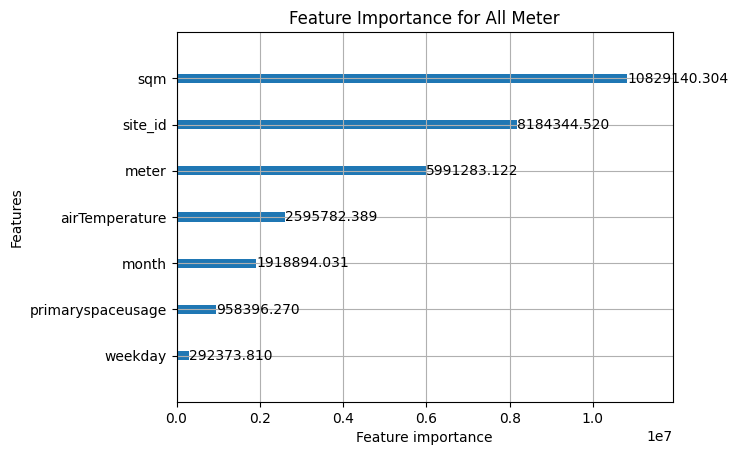

In [68]:
# Plot the feature importance
ax = lgb.plot_importance(final_model, max_num_features=20, importance_type='gain')
plt.title(f"Feature Importance for All Meter")
plt.show()

## Check Model Performance on training dataset

### Define functions to evaluate model

In [69]:
def evaluate_model(model, X_test, y_test, y_scaler):
    # Get predictions
    y_pred_scaled = model.predict(X_test)
    y_pred_log = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_pred = np.expm1(y_pred_log).flatten()  # Transform back from log scale

    # Since y_test is already in original scale, no transformation needed
    y_true = y_test

    # Calculate metrics
    rmse = root_mean_squared_error(y_true, y_pred)
    cvrmse = coefficient_of_variation_root_mean_squared_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    nmbe = normalized_mean_bias_error(y_true, y_pred)
    r2 = r_squared(y_true, y_pred)

    # Create the results DataFrame including X_test features
    results_df = pd.DataFrame(X_test).copy()
    results_df['y_true'] = y_true
    results_df['y_pred'] = y_pred

    return rmse, cvrmse, nmbe, mbe, r2, results_df

### Evaluate model on training dataset

In [70]:
print("Evaluating the model on training set")
# Evaluate the model
rmse, cvrmse, nmbe, mbe, r2, results_df_training = evaluate_model(final_model, X_train_full_processed, y_meter, y_scaler)

# append metrics to 
results_training = []
results_training.append({
    'meter_value': 'all_meter',
    'best_params': best_params,
    'rmse': rmse,
    'cv-rmse': cvrmse,
    'nmbe': nmbe,
})

print(f"Results for all meters on train set:\n \
      RMSE={round(rmse, 4)},\n \
      CV-RMSE={round(cvrmse, 4)} %,\n \
      NMBE={round(nmbe, 4)} %,\n \
      MBE={round(mbe, 4)},\n \
      R2={round(r2, 4)}")


Evaluating the model on training set
Results for all meters on train set:
       RMSE=3132995.0253,
       CV-RMSE=942.4418 %,
       NMBE=58.9857 %,
       MBE=196088.4835,
       R2=0.216


### Visualize Prediction versus Actual on training set

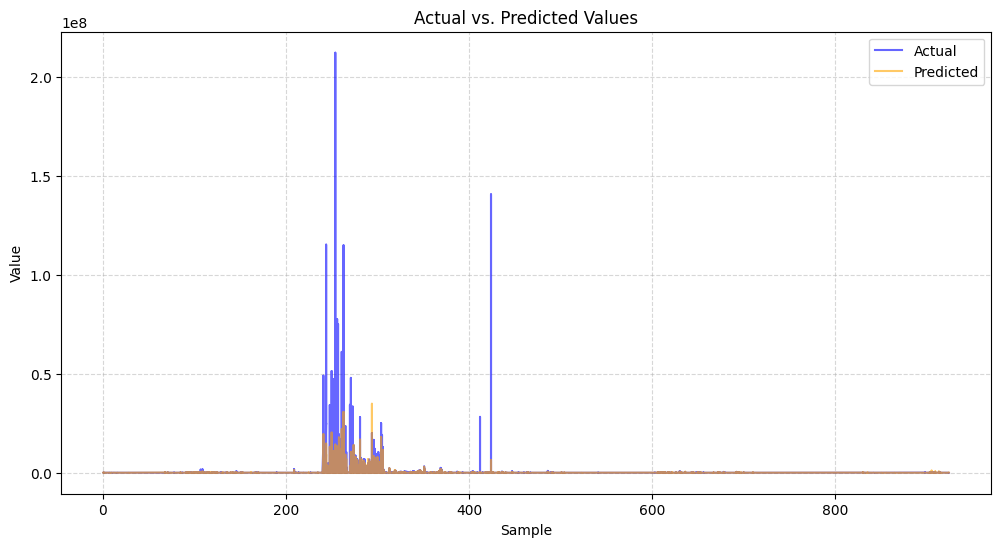

In [71]:
plt.figure(figsize=(12, 6))

# Use contrasting colors and adjust the line width for better visibility
plt.plot(results_df_training['y_true'], label="Actual", color="blue", alpha=0.6, linewidth=1.5)
plt.plot(results_df_training['y_pred'], label="Predicted", color="orange", alpha=0.6, linewidth=1.5)

plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid for better readability

plt.show()

## Evaluate model on test set

In [72]:
print("Evaluating the model on test set")
# Evaluate the model
rmse, cvrmse, nmbe, mbe,r2 ,results_df = evaluate_model(final_model, X_test_processed, y_test, y_scaler)

# append metrics to 
results.append({
    'meter_value': "All meters",
    'best_params': best_params,
    'rmse': rmse,
    'cv-rmse': cvrmse,
    'nmbe': nmbe,
    'r2_score': r2
})

print(f"Results for all meter on test set:\n \
      RMSE={round(rmse, 4)},\n \
      CV-RMSE={round(cvrmse, 4)} %,\n \
      NMBE={round(nmbe, 4)} %,\n \
      MBE={round(mbe, 4)},\n \
      R2={round(r2, 4)}")

Evaluating the model on test set
Results for all meter on test set:
       RMSE=2416184.8852,
       CV-RMSE=815.5956 %,
       NMBE=54.2474 %,
       MBE=160706.7045,
       R2=0.2682


In [73]:
results_df.sample(10)

,meter,primaryspaceusage,sqm,airTemperature,month,weekday,site_id,y_true,y_pred
building_id,,,,,,,,,
238,electricity,Education,0.207419,0.759295,9,6,5,8195.3750,6348.010660
700,electricity,Education,-0.502754,-0.322889,3,4,13,957.3898,726.856930
374,hotwater,Office,0.116100,1.101468,8,5,7,0.0000,14925.049926
765,electricity,Education,1.571121,-0.728627,11,6,14,10549.4000,7154.371671
667,electricity,Office,0.237989,-1.064075,2,3,12,1949.4762,0.612803
211,chilledwater,Education,-1.259152,0.142635,4,3,4,2129.2677,311.874572
103,electricity,Education,1.090656,-1.208727,1,1,3,7775.0000,1058.722739
768,electricity,Education,-0.057274,-2.061496,12,4,14,0.0000,45.610751
720,electricity,Education,-0.160633,-0.122375,5,1,14,0.0000,1.388158


### Visualize actual versus predictions on test set

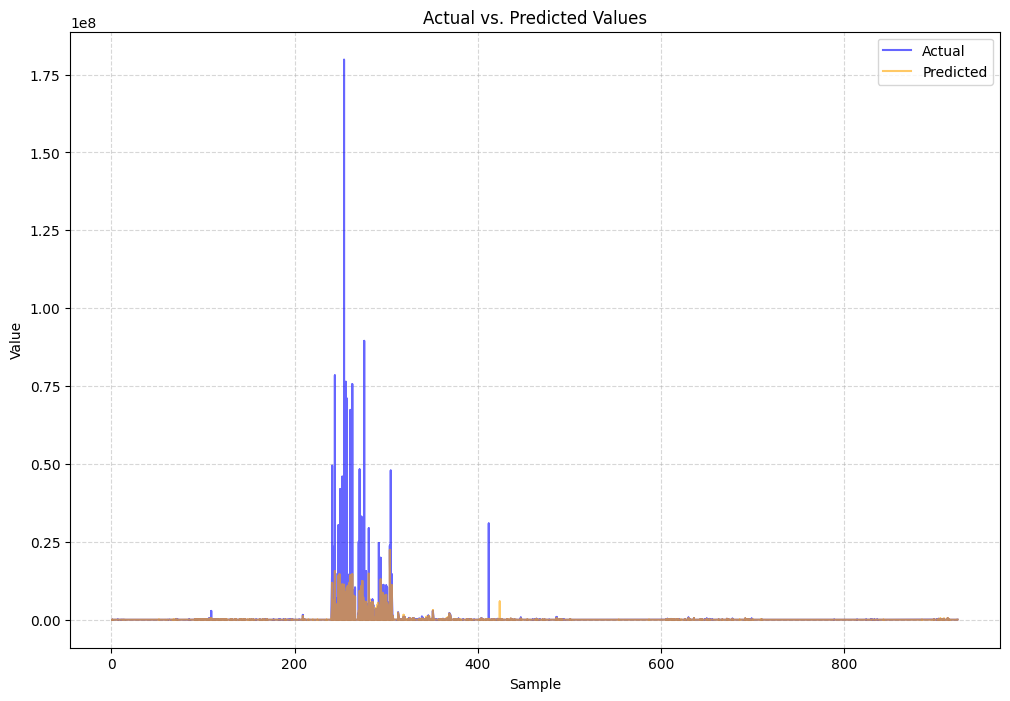

In [74]:
plt.figure(figsize=(12, 8))

# Use contrasting colors and adjust the line width for better visibility
plt.plot(results_df['y_true'], label="Actual", color="blue", alpha=0.6, linewidth=1.5)
plt.plot(results_df['y_pred'], label="Predicted", color="orange", alpha=0.6, linewidth=1.5)

plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid for better readability

plt.show()

## Save model checkpoint

#### Save the scaler as well

In [82]:
model_data = {
    "model": final_model,
    "scaler": scaler,
    "y_scaler": y_scaler
}

# Save everything in a single file
joblib.dump(model_data, "../models/lgbm_all_meter.joblib")
print("Model and scalers saved successfully.")

Model and scalers saved successfully.
